# Notebook: Simulación, Ajuste Estadístico y Definición de Proyecto GRD

## Introducción

Bienvenidos a esta actividad práctica del curso "Análisis de Datos e Inferencia Estadística". Este notebook tiene tres objetivos principales:

1. Reforzar conceptos de simulación de datos y pruebas de ajuste usando NumPy y SciPy
2. Explorar los datos de Grupos Relacionados por Diagnóstico (GRD) de hospitales chilenos
3. Guiarlos en la formulación de su proyecto de investigación semestral

Los GRD son un sistema de clasificación de pacientes hospitalarios que relaciona los diagnósticos, procedimientos y características clínicas con los recursos consumidos durante la estancia hospitalaria. Este sistema es fundamental para la gestión hospitalaria, financiamiento y comparación entre centros de salud.

## Parte 1: Simulación de Datos y Pruebas de Ajuste

La simulación estadística nos permite generar datos artificiales que siguen ciertos patrones o distribuciones. Esto es útil para:
- Entender el comportamiento de modelos estadísticos
- Evaluar métodos de análisis
- Realizar pruebas cuando no se dispone de datos suficientes
- Comparar datos reales con distribuciones teóricas

### 1.1 Importación de librerías necesarias

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import datetime as dt

# Configuraciones de visualización
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("talk")
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['figure.dpi'] = 100

### 1.2 Simulación de datos hospitalarios

Vamos a simular algunos datos relevantes en el contexto hospitalario:
- Tiempo de estadía (días)
- Edad de pacientes
- Costos de hospitalización

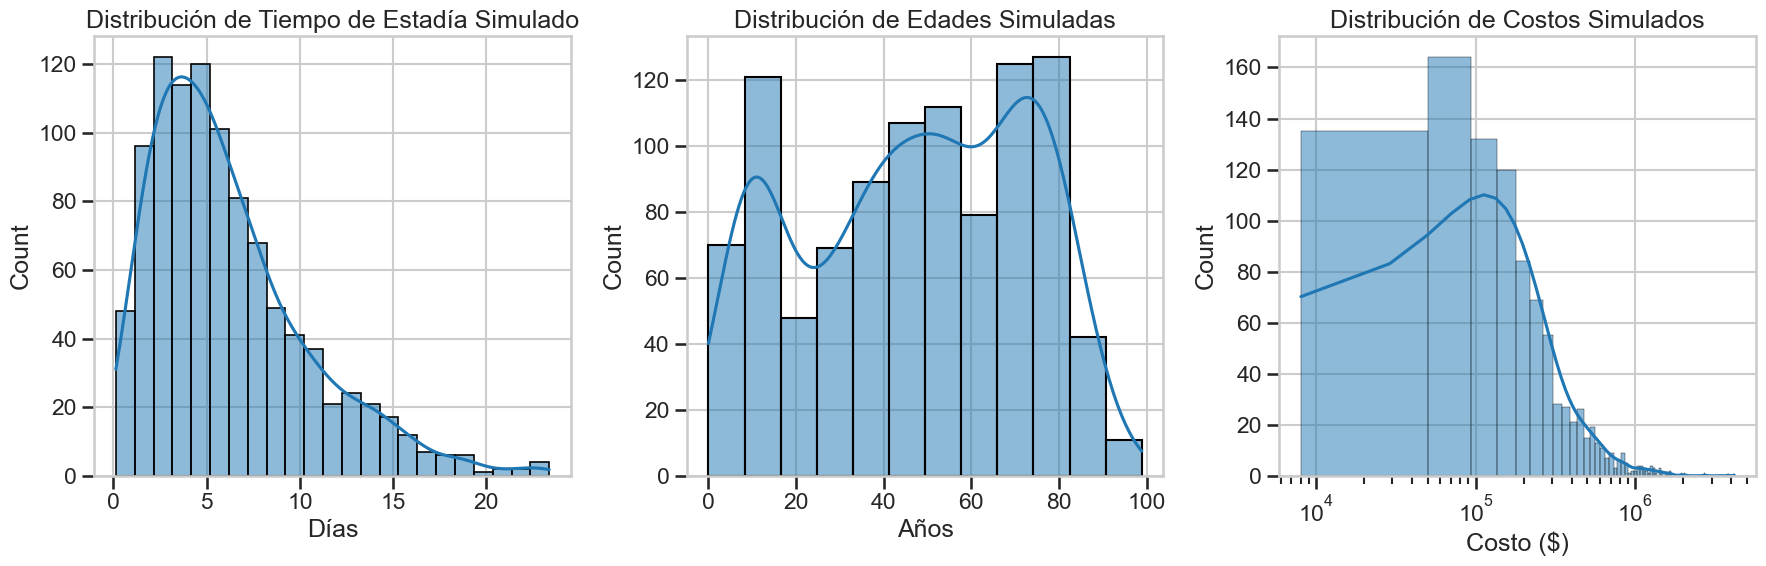

In [2]:
# Configuramos una semilla para reproducibilidad
np.random.seed(42)

# Simulamos tiempos de estadía siguiendo una distribución gamma (común en tiempos de hospitalización)
# Parámetros: shape=2 (forma), scale=3 (escala)
estadia_simulada = np.random.gamma(shape=2, scale=3, size=1000)

# Simulamos edades de pacientes con una mezcla de distribuciones normales
# Para representar diferentes grupos etarios (pediátricos, adultos, adultos mayores)
edades_pediatricos = np.random.normal(loc=10, scale=5, size=200)
edades_adultos = np.random.normal(loc=45, scale=15, size=500)
edades_mayores = np.random.normal(loc=75, scale=8, size=300)
edades_simuladas = np.concatenate([edades_pediatricos, edades_adultos, edades_mayores])
np.random.shuffle(edades_simuladas)
edades_simuladas = np.clip(edades_simuladas, 0, 100)  # Limitamos edades entre 0 y 100 años

# Simulamos costos hospitalarios con distribución log-normal (común en variables monetarias)
costos_simulados = np.random.lognormal(mean=12, sigma=1, size=1000)

# Visualizamos las distribuciones
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Estadía
sns.histplot(estadia_simulada, kde=True, ax=axes[0])
axes[0].set_title('Distribución de Tiempo de Estadía Simulado')
axes[0].set_xlabel('Días')

# Edades
sns.histplot(edades_simuladas, kde=True, ax=axes[1])
axes[1].set_title('Distribución de Edades Simuladas')
axes[1].set_xlabel('Años')

# Costos
sns.histplot(costos_simulados, kde=True, ax=axes[2])
axes[2].set_title('Distribución de Costos Simulados')
axes[2].set_xlabel('Costo ($)')
axes[2].set_xscale('log')

plt.tight_layout()
plt.show()

### 1.3 Pruebas de ajuste a distribuciones teóricas

Las pruebas de ajuste nos permiten determinar si nuestros datos siguen una distribución teórica conocida. Esto es útil para:
- Validar supuestos de modelos estadísticos
- Identificar patrones y anomalías en los datos
- Realizar simulaciones más precisas

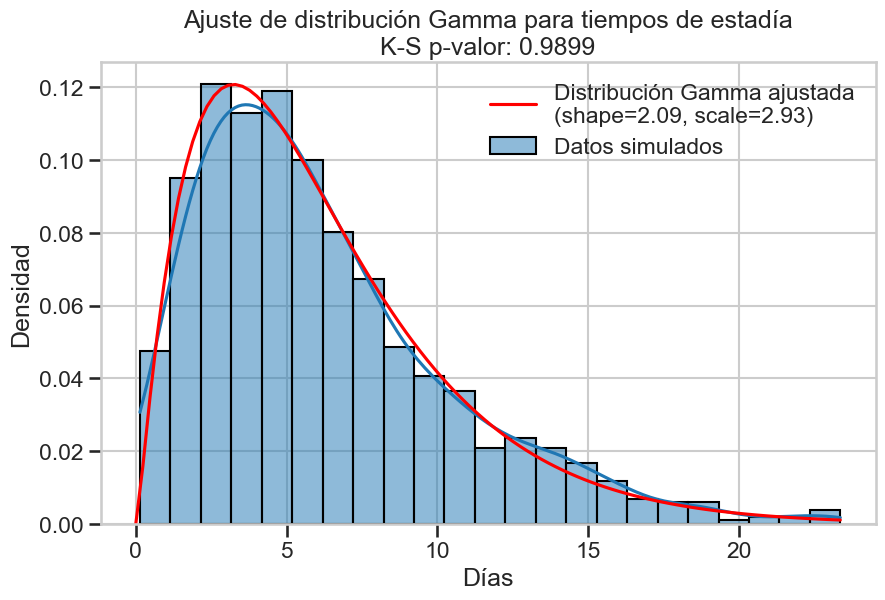

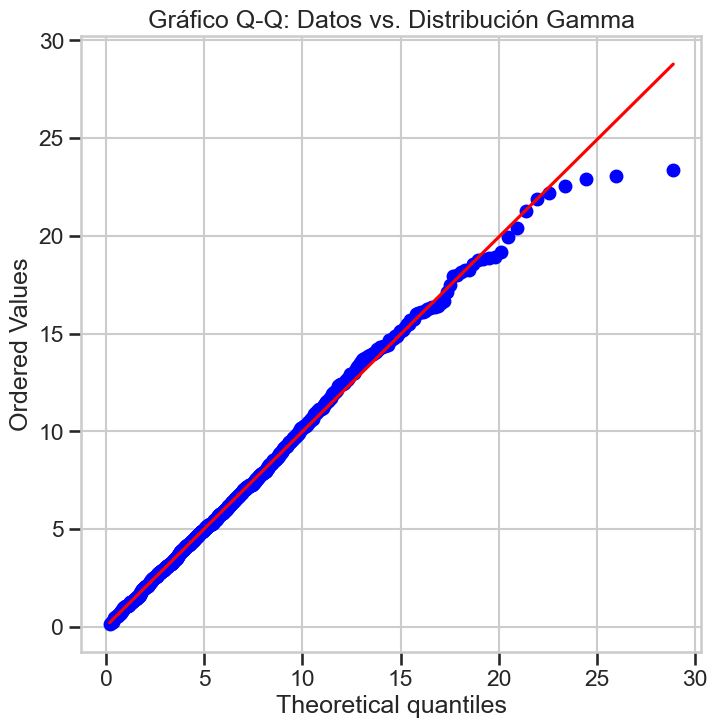

In [3]:
# Verificamos si la estadía sigue una distribución gamma
# Estimamos los parámetros de la distribución gamma a partir de los datos
shape, loc, scale = stats.gamma.fit(estadia_simulada)

# Generamos puntos para la distribución ajustada
x = np.linspace(0, max(estadia_simulada), 100)
pdf_gamma = stats.gamma.pdf(x, shape, loc, scale)

# Prueba de Kolmogorov-Smirnov
ks_stat, ks_pval = stats.kstest(estadia_simulada, 'gamma', args=(shape, loc, scale)) #test

# Visualizamos el ajuste
plt.figure(figsize=(10, 6))
sns.histplot(estadia_simulada, kde=True, stat='density', label='Datos simulados')
plt.plot(x, pdf_gamma, 'r-', label=f'Distribución Gamma ajustada\n(shape={shape:.2f}, scale={scale:.2f})')
plt.title(f'Ajuste de distribución Gamma para tiempos de estadía\nK-S p-valor: {ks_pval:.4f}')
plt.xlabel('Días')
plt.ylabel('Densidad')
plt.legend()
plt.show()

# Gráfico Q-Q para verificar visualmente el ajuste
plt.figure(figsize=(8, 8))
stats.probplot(estadia_simulada, dist=stats.gamma(shape, loc, scale), plot=plt)
plt.title('Gráfico Q-Q: Datos vs. Distribución Gamma')
plt.show()

### 1.4 Ejercicio: Ajuste de distribuciones a edades simuladas

Ahora es su turno. Complete el siguiente código para:
1. Ajustar una distribución normal a la variable de edades simuladas
2. Realizar una prueba de Kolmogorov-Smirnov
3. Visualizar el ajuste con un histograma y la curva teórica
4. Interpretar los resultados

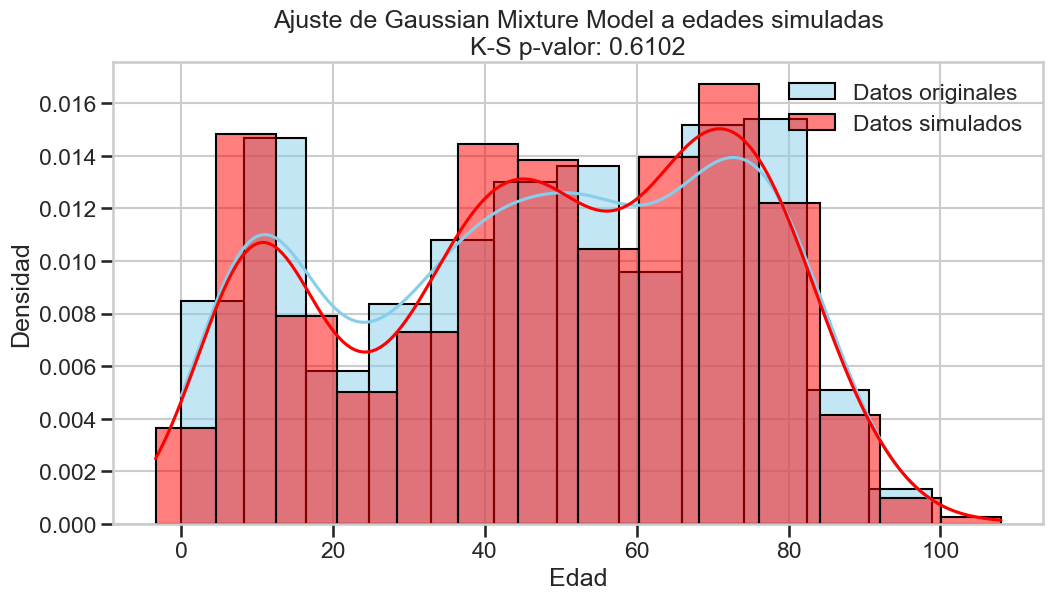

Resultados de la prueba K-S:
Estadístico K-S: 0.0340
p-valor: 0.6102
Conclusión: No se rechaza la hipótesis nula (buen ajuste)


In [4]:
from sklearn.mixture import GaussianMixture
from scipy.stats import ks_2samp

# Ajustamos un modelo de mezcla gaussiana a los datos de edades simuladas
gmm = GaussianMixture(n_components=3, random_state=42)
gmm.fit(edades_simuladas.reshape(-1, 1))

# Obtenemos las probabilidades de pertenencia a cada componente
probs = gmm.predict_proba(edades_simuladas.reshape(-1, 1))

# Generamos datos simulados a partir del modelo ajustado
simulated_data = gmm.sample(len(edades_simuladas))[0].flatten()

# Prueba de Kolmogorov-Smirnov entre los datos originales y los simulados
ks_stat, ks_pval = ks_2samp(edades_simuladas, simulated_data)

# Visualizamos el ajuste
plt.figure(figsize=(12, 6))
sns.histplot(edades_simuladas, kde=True, stat='density', label='Datos originales', color='skyblue')
sns.histplot(simulated_data, kde=True, stat='density', label='Datos simulados', color='red', alpha=0.5)
plt.title(f'Ajuste de Gaussian Mixture Model a edades simuladas\nK-S p-valor: {ks_pval:.4f}')
plt.xlabel('Edad')
plt.ylabel('Densidad')
plt.legend()
plt.show()

# Mostramos los resultados de la prueba K-S
print(f"Resultados de la prueba K-S:")
print(f"Estadístico K-S: {ks_stat:.4f}")
print(f"p-valor: {ks_pval:.4f}")
print(f"Conclusión: {'No se rechaza la hipótesis nula (buen ajuste)' if ks_pval > 0.05 else 'Se rechaza la hipótesis nula (mal ajuste)'}")

In [5]:
# Imprimimos los parámetros de media y desviación estándar de las componentes gaussianas
for i in range(gmm.n_components):
    mean = gmm.means_[i][0]
    std_dev = np.sqrt(gmm.covariances_[i][0][0])
    print(f"Componente {i+1}:")
    print(f"  Media: {mean:.2f}")
    print(f"  Desviación estándar: {std_dev:.2f}")

Componente 1:
  Media: 10.27
  Desviación estándar: 5.21
Componente 2:
  Media: 74.11
  Desviación estándar: 8.79
Componente 3:
  Media: 43.61
  Desviación estándar: 12.53


In [6]:
# Paso 1: Dividir los datos en tres grupos
edades_pediatricos = edades_simuladas[edades_simuladas <= 18]
edades_adultos = edades_simuladas[(edades_simuladas > 18) & (edades_simuladas <= 65)]
edades_mayores = edades_simuladas[edades_simuladas > 65]

# Paso 2: Ajustar una distribución normal a cada grupo
params_pediatricos = stats.norm.fit(edades_pediatricos)
params_adultos = stats.norm.fit(edades_adultos)
params_mayores = stats.norm.fit(edades_mayores)

# Paso 3: Realizar una prueba de Kolmogorov-Smirnov (K-S)
ks_stat_pediatricos, ks_pval_pediatricos = stats.kstest(edades_pediatricos, 'norm', params_pediatricos)
ks_stat_adultos, ks_pval_adultos = stats.kstest(edades_adultos, 'norm', params_adultos)
ks_stat_mayores, ks_pval_mayores = stats.kstest(edades_mayores, 'norm', params_mayores)

In [7]:
# Mostrar resultados de los parámetros y pruebas K-S
print("Resultados del ajuste de distribuciones normales:")
print(f"\nPediátricos:")
print(f"  Media: {params_pediatricos[0]:.2f}, Desviación estándar: {params_pediatricos[1]:.2f}")
print(f"  p-valor K-S: {ks_pval_pediatricos:.4f} {'(Buen ajuste)' if ks_pval_pediatricos > 0.05 else '(Rechaza ajuste)'}")

print(f"\nAdultos:")
print(f"  Media: {params_adultos[0]:.2f}, Desviación estándar: {params_adultos[1]:.2f}")
print(f"  p-valor K-S: {ks_pval_adultos:.4f} {'(Buen ajuste)' if ks_pval_adultos > 0.05 else '(Rechaza ajuste)'}")

print(f"\nMayores:")
print(f"  Media: {params_mayores[0]:.2f}, Desviación estándar: {params_mayores[1]:.2f}")
print(f"  p-valor K-S: {ks_pval_mayores:.4f} {'(Buen ajuste)' if ks_pval_mayores > 0.05 else '(Rechaza ajuste)'}")

Resultados del ajuste de distribuciones normales:

Pediátricos:
  Media: 9.51, Desviación estándar: 4.39
  p-valor K-S: 0.8006 (Buen ajuste)

Adultos:
  Media: 43.93, Desviación estándar: 12.24
  p-valor K-S: 0.0234 (Rechaza ajuste)

Mayores:
  Media: 76.11, Desviación estándar: 6.97
  p-valor K-S: 0.1636 (Buen ajuste)


<>:8: SyntaxWarning: invalid escape sequence '\m'
<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:16: SyntaxWarning: invalid escape sequence '\m'
<>:16: SyntaxWarning: invalid escape sequence '\s'
<>:24: SyntaxWarning: invalid escape sequence '\m'
<>:24: SyntaxWarning: invalid escape sequence '\s'
<>:8: SyntaxWarning: invalid escape sequence '\m'
<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:16: SyntaxWarning: invalid escape sequence '\m'
<>:16: SyntaxWarning: invalid escape sequence '\s'
<>:24: SyntaxWarning: invalid escape sequence '\m'
<>:24: SyntaxWarning: invalid escape sequence '\s'
C:\Users\lenovo\AppData\Local\Temp\ipykernel_6400\1485955853.py:8: SyntaxWarning: invalid escape sequence '\m'
  axes[0].plot(x, pdf_pediatricos, 'r-', label=f'Norm ajustada\n$\mu$={params_pediatricos[0]:.2f}, $\sigma$={params_pediatricos[1]:.2f}')
C:\Users\lenovo\AppData\Local\Temp\ipykernel_6400\1485955853.py:8: SyntaxWarning: invalid escape sequence '\s'
  axes[0].plot(x, pdf_pediatrico

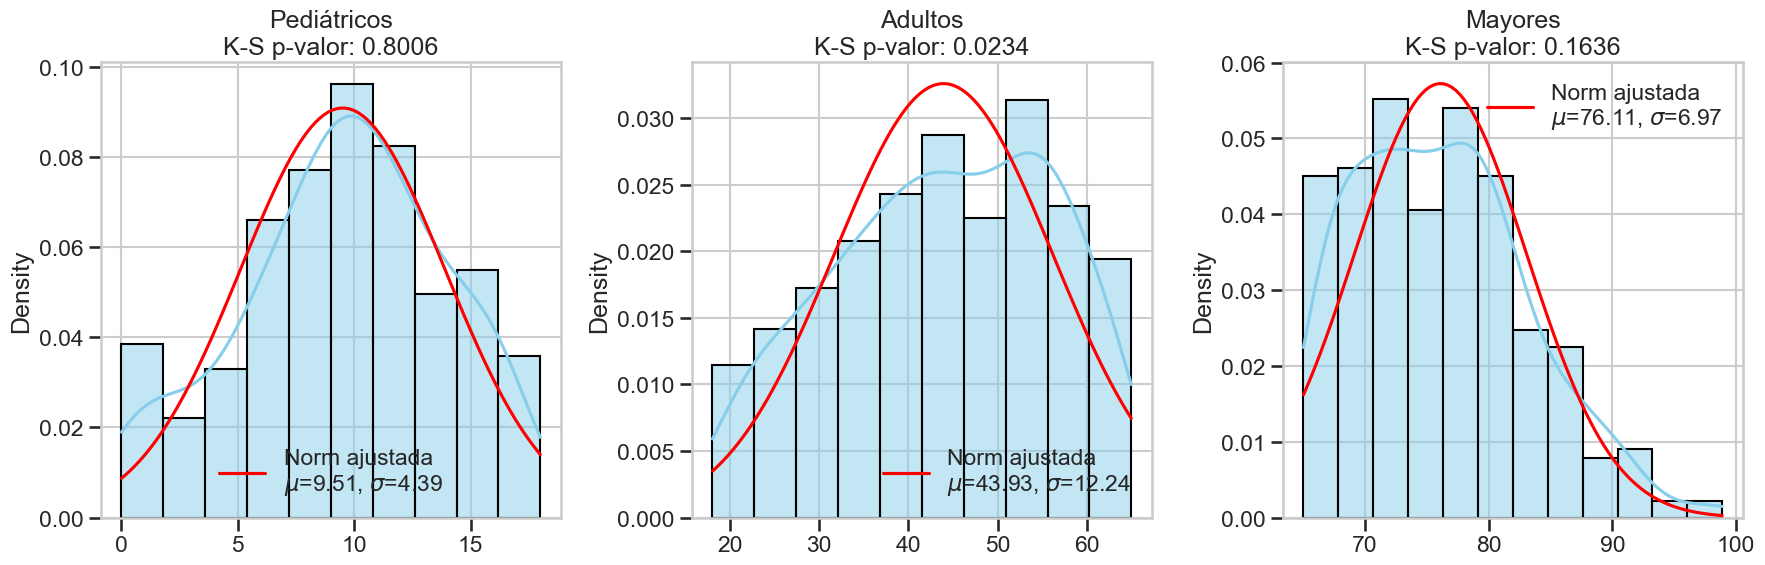

In [8]:
# Paso 4: Visualizar los ajustes
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Pediátricos
sns.histplot(edades_pediatricos, kde=True, stat='density', ax=axes[0], color='skyblue')
x = np.linspace(min(edades_pediatricos), max(edades_pediatricos), 100)
pdf_pediatricos = stats.norm.pdf(x, *params_pediatricos)
axes[0].plot(x, pdf_pediatricos, 'r-', label=f'Norm ajustada\n$\mu$={params_pediatricos[0]:.2f}, $\sigma$={params_pediatricos[1]:.2f}')
axes[0].set_title(f'Pediátricos\nK-S p-valor: {ks_pval_pediatricos:.4f}')
axes[0].legend()

# Adultos
sns.histplot(edades_adultos, kde=True, stat='density', ax=axes[1], color='skyblue')
x = np.linspace(min(edades_adultos), max(edades_adultos), 100)
pdf_adultos = stats.norm.pdf(x, *params_adultos)
axes[1].plot(x, pdf_adultos, 'r-', label=f'Norm ajustada\n$\mu$={params_adultos[0]:.2f}, $\sigma$={params_adultos[1]:.2f}')
axes[1].set_title(f'Adultos\nK-S p-valor: {ks_pval_adultos:.4f}')
axes[1].legend()

# Mayores
sns.histplot(edades_mayores, kde=True, stat='density', ax=axes[2], color='skyblue')
x = np.linspace(min(edades_mayores), max(edades_mayores), 100)
pdf_mayores = stats.norm.pdf(x, *params_mayores)
axes[2].plot(x, pdf_mayores, 'r-', label=f'Norm ajustada\n$\mu$={params_mayores[0]:.2f}, $\sigma$={params_mayores[1]:.2f}')
axes[2].set_title(f'Mayores\nK-S p-valor: {ks_pval_mayores:.4f}')
axes[2].legend()

plt.tight_layout()
plt.show()


In [9]:
# Ajustamos distribución normal a las edades
# Completar: Estime los parámetros de la distribución normal (media y desviación estándar)
# media, desv_est = ?

# Prueba de Kolmogorov-Smirnov
# Completar: Realice la prueba K-S entre las edades simuladas y la distribución normal
# ks_stat_edad, ks_pval_edad = ?

# Visualización
# Completar: Genere un histograma con la densidad de las edades y superponga la curva teórica
# plt.figure(figsize=(10, 6))
# ...

# Interpretación:
# Si el p-valor es mayor a 0.05, no podemos rechazar la hipótesis nula que los datos 
# siguen la distribución teórica. Si es menor, se rechaza el ajuste a esa distribución.

## Parte 2: Exploración de Datos GRD

Ahora vamos a explorar los datos reales de GRD que utilizaremos para nuestros proyectos.

### 2.1 Carga y exploración inicial de datos

In [15]:
# Cargamos los datos (usamos una muestra para este notebook)
# En caso de que no funcione la carga directa, ajustar la ruta al archivo
import polars as pl

try:
    columnas_fecha = ["FECHA_NACIMIENTO", "FECHA_INGRESO", "FECHAALTA"]
    df = pl.scan_csv("data/GRD_2023_muestra_cancer_UCV.csv", null_values=["DESCONOCIDO"])
    df = df.with_columns([
        pl.coalesce([
            pl.col(col).str.strptime(pl.Date, "%d-%m-%Y", strict=False),
            pl.col(col).str.strptime(pl.Date, "%Y-%m-%d", strict=False)
        ]).alias(col)  # 
        for col in columnas_fecha
    ])
    # Finalmente, materializamos el DataFrame en memoria (si usas lazy):
    df = df.collect()
    grd_data = df.to_pandas()
    print("CSV CARGADO")

except:
    # Este es un dataset simulado para el notebook en caso de no tener acceso al archivo real
    # Solo para fines didácticos
    n_samples = 1000
    grd_data = pd.DataFrame({
        'COD_HOSPITAL': np.random.randint(100000, 200000, n_samples),
        'CIP_ENCRIPTADO': np.random.randint(1000000, 9000000, n_samples),
        'SEXO': np.random.choice(['M', 'F'], n_samples),
        'FECHA_NACIMIENTO': [pd.Timestamp('1940-01-01') + 
                            pd.Timedelta(days=np.random.randint(0, 365*70)) for _ in range(n_samples)],
        'SERVICIO_SALUD': np.random.choice(['METROPOLITANO CENTRAL', 'METROPOLITANO NORTE', 
                                          'METROPOLITANO SUR', 'METROPOLITANO ORIENTE'], n_samples),
        'TIPO_INGRESO': np.random.choice(['URGENCIA', 'ELECTIVO'], n_samples),
        'FECHA_INGRESO': [pd.Timestamp('2023-01-01') + 
                          pd.Timedelta(days=np.random.randint(0, 364)) for _ in range(n_samples)],
        'FECHAALTA': [pd.Timestamp('2023-01-01') + 
                     pd.Timedelta(days=np.random.randint(1, 365)) for _ in range(n_samples)],
        'TIPOALTA': np.random.choice(['DOMICILIO', 'TRASLADO', 'FALLECIMIENTO'], 
                                   n_samples, p=[0.8, 0.15, 0.05]),
        'DIAGNOSTICO1': np.random.choice(['C61', 'C67', 'C64', 'C50', 'I10'], 
                                       n_samples, p=[0.3, 0.2, 0.2, 0.2, 0.1]),
        'IR_29301_COD_GRD': np.random.choice([101101, 101102, 101103, 114101, 114102], n_samples),
        'IR_29301_PESO': np.random.uniform(0.5, 3.0, n_samples).astype(str),
        'IR_29301_SEVERIDAD': np.random.choice([0, 1, 2, 3], n_samples),
        'IR_29301_MORTALIDAD': np.random.choice([0, 1, 2, 3], n_samples),
    })
    print("CSV NOT FOUND")

# Mostramos información básica del dataframe
print("Información del dataset GRD:")
print(f"Tamaño: {grd_data.shape[0]} filas, {grd_data.shape[1]} columnas")
print("\nColumnas disponibles:")
for col in grd_data.columns:
    print(f"- {col}")
    
print("\nPrimeras 5 filas:")
grd_data.head()

CSV CARGADO
Información del dataset GRD:
Tamaño: 1039587 filas, 14 columnas

Columnas disponibles:
- COD_HOSPITAL
- CIP_ENCRIPTADO
- SEXO
- FECHA_NACIMIENTO
- SERVICIO_SALUD
- TIPO_INGRESO
- FECHA_INGRESO
- FECHAALTA
- TIPOALTA
- DIAGNOSTICO1
- IR_29301_COD_GRD
- IR_29301_PESO
- IR_29301_SEVERIDAD
- IR_29301_MORTALIDAD

Primeras 5 filas:


,COD_HOSPITAL,CIP_ENCRIPTADO,SEXO,FECHA_NACIMIENTO,SERVICIO_SALUD,TIPO_INGRESO,FECHA_INGRESO,FECHAALTA,TIPOALTA,DIAGNOSTICO1,IR_29301_COD_GRD,IR_29301_PESO,IR_29301_SEVERIDAD,IR_29301_MORTALIDAD
0,122100,72196813.0,HOMBRE,1980-04-13,VALDIVIA,URGENCIA,2023-03-12,2023-03-14,DOMICILIO,K35.3,64161.0,"0,7094",1.0,1.0
1,114101,NaN,HOMBRE,2001-11-04,METROPOLITANO SURORIENTE,URGENCIA,2023-11-04,2023-11-10,DOMICILIO,J93.1,41301.0,"1,0869",1.0,1.0
2,114101,97627974.0,HOMBRE,2020-07-30,METROPOLITANO SURORIENTE,URGENCIA,2023-06-07,2023-06-08,HOSPITALIZACIÓN DOMICILIARIA,J12.1,44161.0,"0,4084",1.0,1.0
3,106103,67770674.0,MUJER,1978-11-14,VALPARAISO SAN ANTONIO,PROGRAMADA,2023-05-25,2023-05-26,DOMICILIO,N39.3,131301.0,"0,6406",1.0,1.0
4,106103,100390800.0,MUJER,2023-12-20,VALPARAISO SAN ANTONIO,URGENCIA,2023-12-28,2023-12-30,DOMICILIO,R17,74131.0,"0,5346",1.0,1.0


### 2.2 Preprocesamiento básico

In [ ]:
# Convertimos las fechas si es necesario
if isinstance(grd_data['FECHA_INGRESO'][0], str):
    grd_data['FECHA_INGRESO'] = pd.to_datetime(grd_data['FECHA_INGRESO'])
    grd_data['FECHAALTA'] = pd.to_datetime(grd_data['FECHAALTA'])
    grd_data['FECHA_NACIMIENTO'] = pd.to_datetime(grd_data['FECHA_NACIMIENTO'])
grd_data.dropna(inplace=True)
# Calculamos variables derivadas
grd_data['EDAD'] = ((grd_data['FECHA_INGRESO'] - grd_data['FECHA_NACIMIENTO']).dt.days / 365.25).round().astype(int)
grd_data['DIAS_ESTANCIA'] = (grd_data['FECHAALTA'] - grd_data['FECHA_INGRESO']).dt.days

# Convertimos el peso GRD a numérico si es necesario
if grd_data['IR_29301_PESO'].dtype == 'object':
    grd_data['IR_29301_PESO'] = grd_data['IR_29301_PESO'].str.replace(',', '.').astype(float)

# Creamos un diccionario para mapear códigos de diagnóstico a descripción
# Esto es una simplificación, en la realidad hay muchos más códigos
diagnostico_map = {
    'C61': 'Neoplasia maligna de próstata',
    'C67': 'Neoplasia maligna de vejiga',
    'C64': 'Neoplasia maligna de riñón',
    'C50': 'Neoplasia maligna de mama',
    'I10': 'Hipertensión esencial (primaria)'
}

# Creamos nueva columna con descripción del diagnóstico
grd_data['DIAGNOSTICO1_DESC'] = grd_data['DIAGNOSTICO1'].map(diagnostico_map)

# Severidad y mortalidad como categóricas
grd_data['SEVERIDAD_CAT'] = grd_data['IR_29301_SEVERIDAD'].map({
    0: 'Sin gravedad', 
    1: 'Menor', 
    2: 'Moderada', 
    3: 'Mayor'
})

grd_data['MORTALIDAD_CAT'] = grd_data['IR_29301_MORTALIDAD'].map({
    0: 'Sin gravedad', 
    1: 'Menor', 
    2: 'Moderada', 
    3: 'Mayor'
})

print("Variables derivadas creadas: EDAD, DIAS_ESTANCIA, DIAGNOSTICO1_DESC, SEVERIDAD_CAT, MORTALIDAD_CAT")

Variables derivadas creadas: EDAD, DIAS_ESTANCIA, DIAGNOSTICO1_DESC, SEVERIDAD_CAT, MORTALIDAD_CAT


### 2.3 Análisis exploratorio inicial

Resumen estadístico de variables numéricas:


,EDAD,DIAS_ESTANCIA,IR_29301_PESO
count,1000.000000,1000.000000,1000.000000
mean,48.439000,-0.185000,1.734394
std,20.392747,148.304305,0.731992
min,13.000000,-349.000000,0.503334
25%,30.750000,-114.000000,1.088128
50%,48.000000,3.000000,1.708292
75%,67.000000,107.000000,2.382498
max,83.000000,349.000000,2.997112



Distribución de diagnósticos principales:


DIAGNOSTICO1_DESC
Neoplasia maligna de próstata       308
Neoplasia maligna de vejiga         208
Neoplasia maligna de mama           204
Neoplasia maligna de riñón          176
Hipertensión esencial (primaria)    104
Name: count, dtype: int64

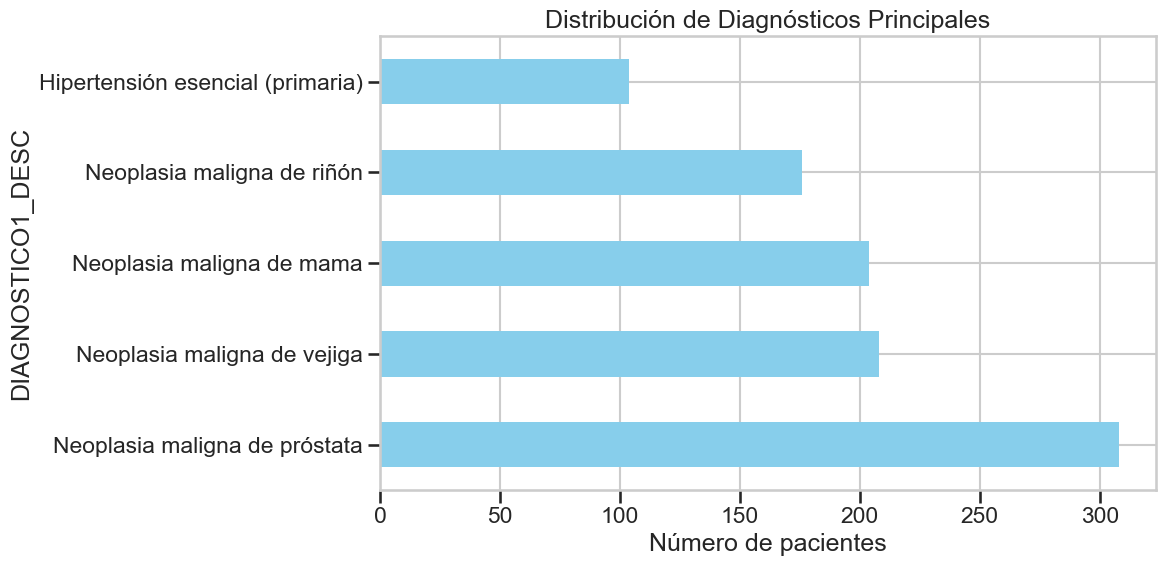

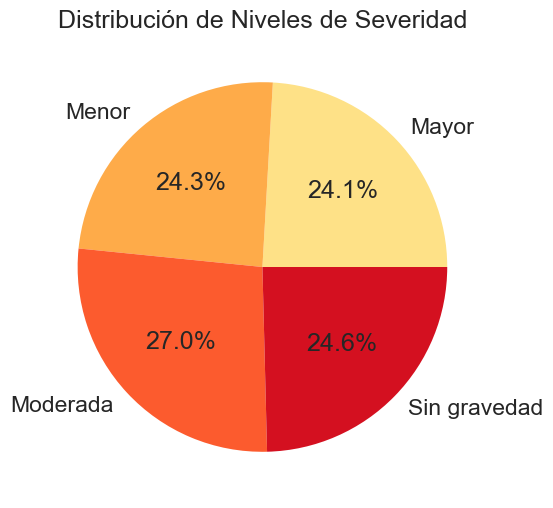

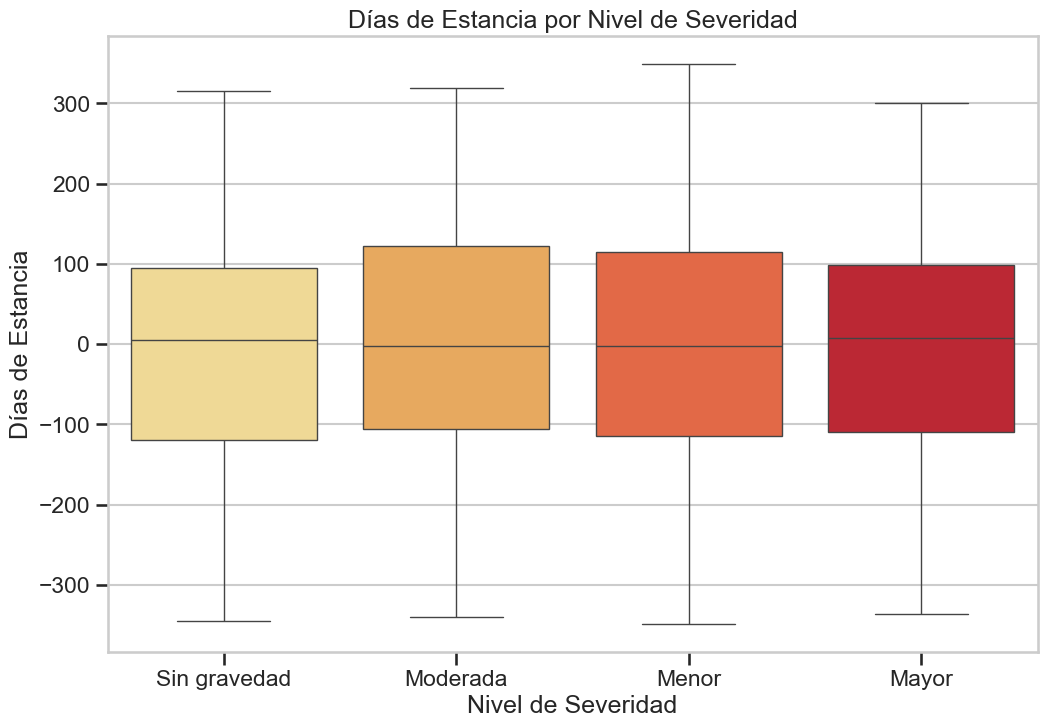

<Figure size 1200x600 with 0 Axes>

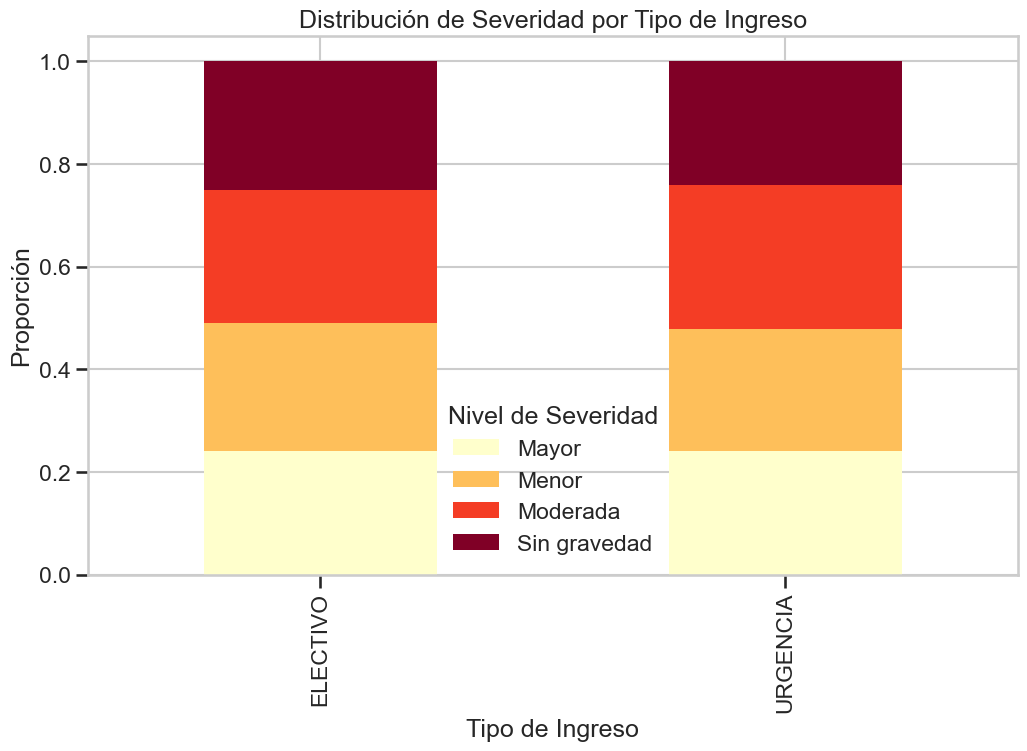

In [ ]:
# Resumen estadístico de variables numéricas clave
print("Resumen estadístico de variables numéricas:")
display(grd_data[['EDAD', 'DIAS_ESTANCIA', 'IR_29301_PESO']].describe())

# Distribución de diagnósticos
print("\nDistribución de diagnósticos principales:")
diag_counts = grd_data['DIAGNOSTICO1_DESC'].value_counts()
display(diag_counts)


#GRAFICO BARRA
plt.figure(figsize=(12, 6))
diag_counts.plot(kind='barh', color='skyblue')
plt.title('Distribución de Diagnósticos Principales')
plt.xlabel('Número de pacientes')
plt.tight_layout()
plt.show()

#GRAFICO PIE
# Distribución de niveles de severidad
plt.figure(figsize=(10, 6))
severity_counts = grd_data['SEVERIDAD_CAT'].value_counts().sort_index()
severity_counts.plot(kind='pie', autopct='%1.1f%%', colors=sns.color_palette("YlOrRd", 4))
plt.title('Distribución de Niveles de Severidad')
plt.ylabel('')  # Ocultar etiqueta del eje Y
plt.show()

# Relación entre edad y días de estancia por severidad
plt.figure(figsize=(12, 8))
sns.boxplot(x='SEVERIDAD_CAT', y='DIAS_ESTANCIA', data=grd_data, palette="YlOrRd", hue='SEVERIDAD_CAT',legend=False)
plt.title('Días de Estancia por Nivel de Severidad')
plt.xlabel('Nivel de Severidad')
plt.ylabel('Días de Estancia')
plt.show()

# Relación entre tipo de ingreso y severidad
plt.figure(figsize=(12, 6))
pd.crosstab(grd_data['TIPO_INGRESO'], grd_data['SEVERIDAD_CAT'], normalize='index').plot(
    kind='bar', stacked=True, colormap='YlOrRd')
plt.title('Distribución de Severidad por Tipo de Ingreso')
plt.xlabel('Tipo de Ingreso')
plt.ylabel('Proporción')
plt.legend(title='Nivel de Severidad')
plt.show()

### 2.4 Ajuste de distribuciones a datos reales de GRD

A continuación, vamos a ajustar distribuciones teóricas a algunas variables clave de los datos GRD.

<Axes: >

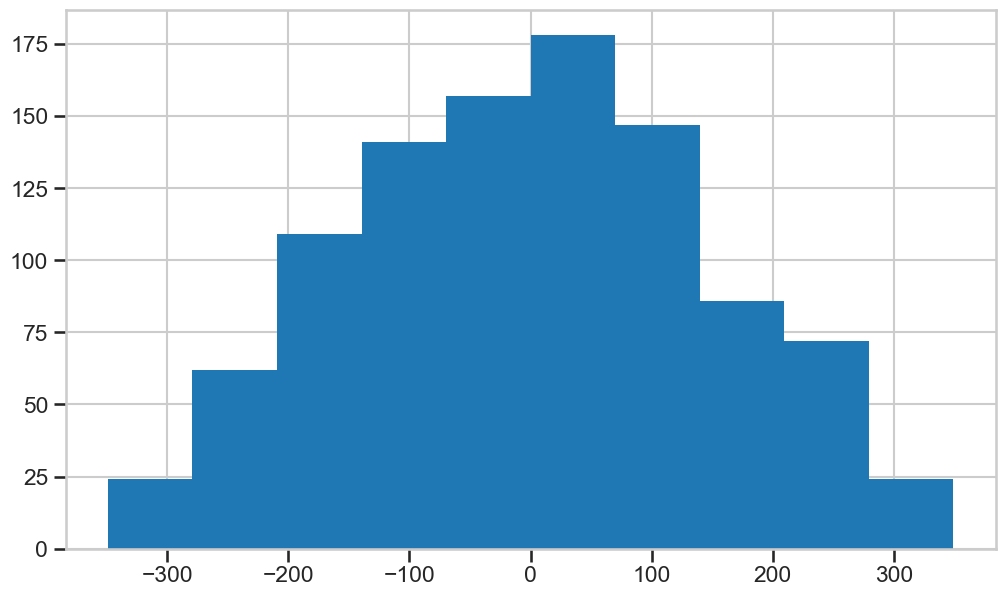

In [ ]:
grd_data['DIAS_ESTANCIA'].hist()

In [ ]:
grd_data['DIAS_ESTANCIA'].describe()

count    1000.000000
mean       -0.185000
std       148.304305
min      -349.000000
25%      -114.000000
50%         3.000000
75%       107.000000
max       349.000000
Name: DIAS_ESTANCIA, dtype: float64

In [ ]:
estancia = grd_data['DIAS_ESTANCIA'].dropna()
estancia

0     -113
1      -93
2     -112
3      -20
4        5
      ... 
995    109
996   -182
997   -113
998     63
999   -222
Name: DIAS_ESTANCIA, Length: 1000, dtype: int64

<Axes: >

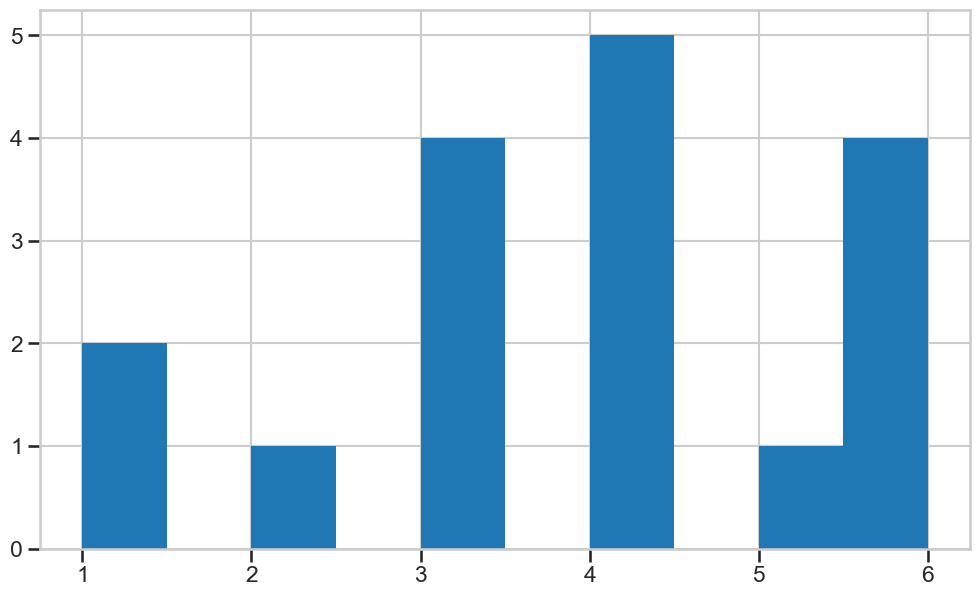

In [ ]:
estancia[(estancia > 0) & (estancia < 7)].hist()

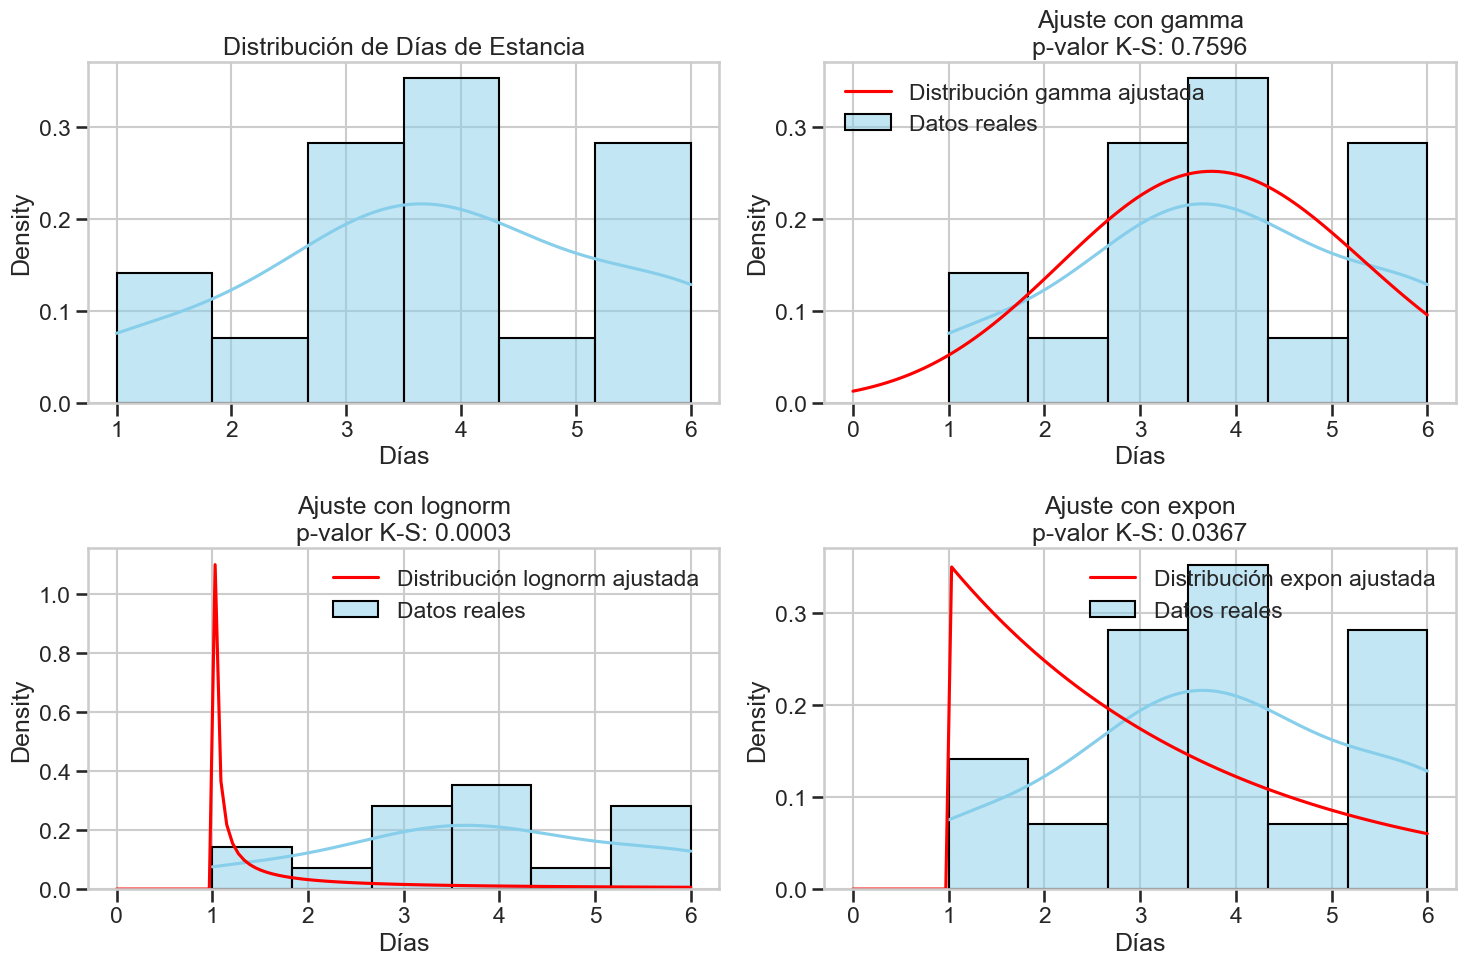

Resultados del ajuste de distribuciones:

Gamma:
  p-valor: 0.7596 (Buen ajuste)
  Estadístico K-S: 0.1540
  Parámetros: 463.2702, -30.3433, 0.0737

Lognorm:
  p-valor: 0.0003 (Rechaza ajuste)
  Estadístico K-S: 0.4908
  Parámetros: 11.9658, 1.0000, 0.0371

Expon:
  p-valor: 0.0367 (Rechaza ajuste)
  Estadístico K-S: 0.3311
  Parámetros: 1.0000, 2.8235


In [ ]:
# Ajustamos distribuciones a los días de estancia
# Filtrar valores válidos y positivos
estancia = grd_data['DIAS_ESTANCIA'].dropna()
estancia = estancia[(estancia > 0) & (estancia < 7)]  # Filtramos valores extremos

# Probamos ajustar varias distribuciones
distribuciones = ['gamma', 'lognorm', 'expon']
resultados_ajuste = {}

plt.figure(figsize=(15, 10))

# Histogram de los datos reales
plt.subplot(2, 2, 1)
sns.histplot(estancia, kde=True, stat='density', color='skyblue')
plt.title('Distribución de Días de Estancia')
plt.xlabel('Días')

# Ajustamos cada distribución y la visualizamos
for i, dist_name in enumerate(distribuciones, 2):
    # Obtenemos la distribución desde scipy.stats
    distribution = getattr(stats, dist_name)
    
    # Ajustamos los parámetros
    params = distribution.fit(estancia)
    
    # Realizamos test K-S
    ks_stat, p_value = stats.kstest(estancia, dist_name, params)
    resultados_ajuste[dist_name] = {'params': params, 'ks_stat': ks_stat, 'p_value': p_value}
    
    # Generamos puntos para graficar la distribución ajustada
    x = np.linspace(0, np.percentile(estancia, 95), 100)
    pdf = distribution.pdf(x, *params)
    
    # Graficamos
    plt.subplot(2, 2, i)
    sns.histplot(estancia, kde=True, stat='density', color='skyblue', label='Datos reales')
    plt.plot(x, pdf, 'r-', label=f'Distribución {dist_name} ajustada')
    plt.title(f'Ajuste con {dist_name}\np-valor K-S: {p_value:.4f}')
    plt.xlabel('Días')
    plt.legend()

plt.tight_layout()
plt.show()

# Mostramos resultados numéricos
print("Resultados del ajuste de distribuciones:")
for dist_name, result in resultados_ajuste.items():
    print(f"\n{dist_name.capitalize()}:")
    print(f"  p-valor: {result['p_value']:.4f} {'(Buen ajuste)' if result['p_value'] > 0.05 else '(Rechaza ajuste)'}")
    print(f"  Estadístico K-S: {result['ks_stat']:.4f}")
    print(f"  Parámetros: {', '.join([f'{p:.4f}' for p in result['params']])}")

## Parte 3: Formulación del Proyecto de Investigación

Ahora que han explorado algunos aspectos de los datos GRD, es momento de comenzar a definir su proyecto de investigación. Este proyecto será desarrollado en grupos de 2-3 estudiantes a lo largo del semestre.

### 3.1 Contexto y delimitación de temas

Los Grupos Relacionados por Diagnóstico (GRD) son un sistema de clasificación de pacientes que permite relacionar el tipo de pacientes que atiende un hospital con los recursos que consume. Este sistema es fundamental para:

1. **Gestión hospitalaria**: Optimizar recursos, comparar centros de salud, identificar ineficiencias
2. **Financiamiento**: Base para establecer pagos por atención (sistema prospectivo)
3. **Calidad asistencial**: Medir resultados ajustados por riesgo y complejidad
4. **Investigación**: Analizar patrones de atención, costos y resultados clínicos

Algunas áreas potenciales para su proyecto:

- **Análisis de eficiencia hospitalaria (x)**: Comparar estadías, costos o mortalidad entre hospitales para diagnósticos similares
- **Estudio de comorbilidades**: Analizar cómo afectan las enfermedades secundarias al costo y resultado
- **Patrones geográficos**: Explorar variaciones regionales en atención y resultados
- **Análisis temporal**: Identificar tendencias o estacionalidad en diagnósticos o admisiones
- **Predictores de severidad**: Identificar factores que predicen mayor severidad o mortalidad

# Plantilla de Definición de Proyecto GRD

Complete claramente cada sección en grupo, proporcionando justificaciones detalladas y coherentes con los objetivos del curso y el contexto del sistema de salud chileno (GRD).

## 1. Integrantes del grupo
- Estudiante 1: Luis Nicolas Pino
- Estudiante 2: Marcial Ibanez 


## 2. Título tentativo del proyecto
Escriba un título claro y específico que refleje el objetivo central del proyecto.

## 3. Declaración del problema desde el usuario
Utilice este formato para formular el problema desde la perspectiva del usuario, en el contexto del sistema GRD:

**(El usuario)** __________________________________ necesita *(necesidad del usuario respecto del espacio de innovación)* __________________________________
**Debido a que** *(causas del problema)* __________________________________
**Lo que provoca** *(consecuencias o efectos del problema)* __________________________________

## 4. Pregunta principal de investigación
Formule una pregunta precisa y enfocada en un problema específico dentro del contexto del sistema GRD chileno. Esta pregunta debe poder responderse mediante el análisis estadístico planteado en este curso.

## ¿Como afectan al costo las enfermedades mas comunes en cada Servicio de Salud Publico?

## 5. Preguntas secundarias (mínimo 2)
Formule preguntas que apoyen la respuesta a la pregunta principal y permitan profundizar en aspectos específicos del problema.
- Pregunta secundaria 1: _______________________________________
- Pregunta secundaria 2: _______________________________________
- (Opcional) Pregunta secundaria 3: _____________________________

## 6. Variables principales y justificación de selección
Seleccione entre 3 y 5 variables claves del conjunto de datos GRD. Explique brevemente por qué son relevantes para responder sus preguntas de investigación.
- Variable 1: __________________ - Justificación: _____________________
- Variable 2: __________________ - Justificación: _____________________
- Variable 3: __________________ - Justificación: _____________________
- (Opcional) Variable 4: ________ - Justificación: _____________________
- (Opcional) Variable 5: ________ - Justificación: _____________________

## 7. Metodología estadística propuesta
Especifique al menos 2 métodos estadísticos que planean emplear y describa claramente su propósito dentro del proyecto.
- Método 1: _____________________ - Propósito: ______________________
- Método 2: _____________________ - Propósito: ______________________
- (Opcional) Método 3: __________ - Propósito: ______________________

## 8. Potencial impacto y aplicación práctica
Describa brevemente cómo los resultados obtenidos pueden impactar al sistema de salud chileno y qué aplicaciones prácticas podrían derivarse de su análisis.

## 9. Supuestos estadísticos necesarios
Enumere claramente los supuestos necesarios para aplicar correctamente las técnicas estadísticas elegidas. Explique brevemente cómo verificarán cada supuesto.
- Supuesto 1: __________________ - Forma de validación: _______________
- Supuesto 2: __________________ - Forma de validación: _______________
- (Opcional) Supuesto 3: ________ - Forma de validación: _______________

## 10. Limitaciones del estudio (sesgos)
Anticipe posibles limitaciones que podrían afectar la validez o generalización de sus resultados y cómo planean mitigarlas.
- Limitación 1: __________________ - Estrategia de mitigación: ___________
- Limitación 2: __________________ - Estrategia de mitigación: ___________
- (Opcional) Limitación 3: ________ - Estrategia de mitigación: ___________

## 11. Cronograma detallado del proyecto
Defina claramente las actividades que realizarán en cada bloque de semanas según el calendario del curso.
- Semanas 4-5: ___________________________________________________
- Semanas 6-7: ___________________________________________________
- Semanas 8-9: ___________________________________________________
- Semanas 10-11: _________________________________________________
- Semana 12 (preparación final): _____________________________________



### 3.3 Guía para formular una buena pregunta de investigación

Una buena pregunta de investigación en análisis de datos GRD debería ser:

1. **Específica**: Claramente delimitada en alcance y población
2. **Medible**: Incluir variables que puedan ser cuantificadas con los datos disponibles
3. **Relevante**: Abordar un problema significativo en gestión hospitalaria o salud pública
4. **Factible**: Posible de responder con los datos y métodos disponibles
5. **Novedosa**: Aportar conocimiento nuevo o perspectivas diferentes

Ejemplos de preguntas bien formuladas:

- "¿Cuál es la relación entre el número de comorbilidades y la duración de estadía hospitalaria en pacientes con cáncer genitourinario?"
- "¿Existen diferencias significativas en la severidad de hospitalización entre ingresos electivos y de urgencia para los mismos códigos GRD?"
- "¿Qué factores demográficos y clínicos predicen mejor la mortalidad hospitalaria en pacientes con diagnóstico de cáncer de próstata?"

### 3.4 Actividad final: Simulación relacionada con su pregunta de investigación

Para completar este notebook, realice una simulación estadística que se relacione con su potencial pregunta de investigación. Esta simulación debe:

1. Generar datos que modelen el fenómeno que quieren estudiar
2. Aplicar una prueba estadística apropiada
3. Interpretar los resultados en el contexto de su proyecto

C:\Users\Marcial\AppData\Local\Temp\ipykernel_16536\1007799679.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dias_estancia[i] = np.random.gamma(shape=3, scale=3, size=1)
C:\Users\Marcial\AppData\Local\Temp\ipykernel_16536\1007799679.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dias_estancia[i] = np.random.gamma(shape=2, scale=2.5, size=1)
C:\Users\Marcial\AppData\Local\Temp\ipykernel_16536\1007799679.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

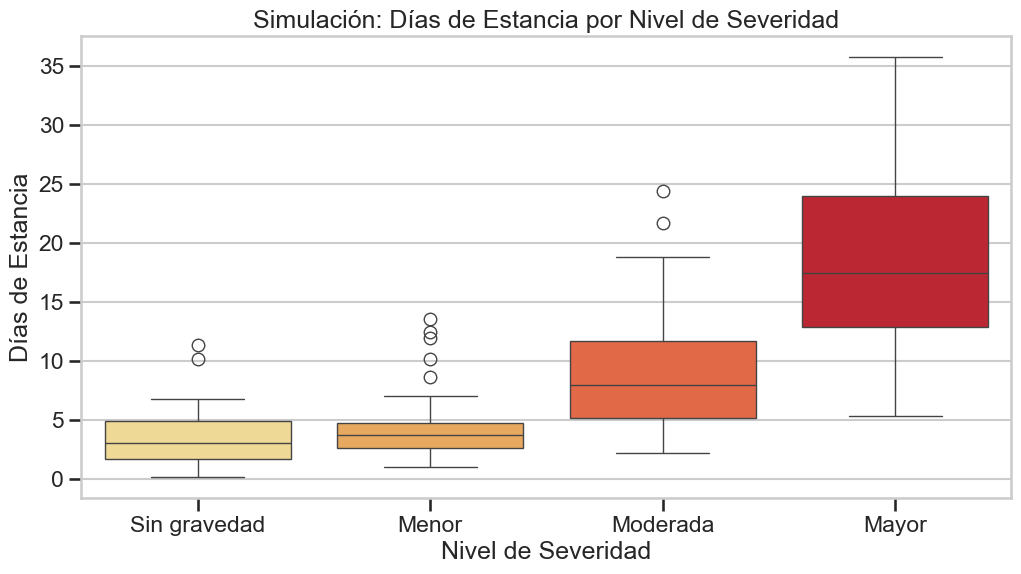

Resultados del ANOVA:
Estadístico F: 95.8371
p-valor: 0.0000
Conclusión: Hay diferencias significativas entre los grupos

Estadísticas descriptivas por nivel de severidad:


C:\Users\Marcial\AppData\Local\Temp\ipykernel_16536\1007799679.py:62: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  display(sim_data.groupby('severidad_cat')['dias_estancia'].describe())


,count,mean,std,min,25%,50%,75%,max
severidad_cat,,,,,,,,
Sin gravedad,34.0,3.474446,2.561910,0.156534,1.664787,3.053528,4.897244,11.354243
Menor,61.0,4.227147,2.632614,1.001266,2.634266,3.714896,4.774154,13.576117
Moderada,71.0,8.733614,4.739377,2.224324,5.147460,7.957648,11.655595,24.349483
Mayor,34.0,19.157973,7.315318,5.296706,12.891653,17.407635,23.959590,35.723573


In [ ]:
# Ejemplo (modifique según su pregunta de investigación):

# Supongamos que queremos investigar la diferencia en días de estancia entre 
# pacientes con diferentes niveles de severidad

# 1. Simulamos datos
np.random.seed(123)
n = 200  # número de pacientes

# Severidad como variable categórica (0, 1, 2, 3)
severidad = np.random.choice([0, 1, 2, 3], size=n, p=[0.2, 0.3, 0.3, 0.2])

# Días de estancia que aumentan con la severidad (simulando una relación)
# Usamos diferentes parámetros de distribución gamma para cada nivel de severidad
dias_estancia = np.zeros(n)
for i in range(n):
    if severidad[i] == 0:
        dias_estancia[i] = np.random.gamma(shape=1.5, scale=2, size=1)
    elif severidad[i] == 1:
        dias_estancia[i] = np.random.gamma(shape=2, scale=2.5, size=1)
    elif severidad[i] == 2:
        dias_estancia[i] = np.random.gamma(shape=3, scale=3, size=1)
    else:  # severidad 3
        dias_estancia[i] = np.random.gamma(shape=4, scale=4, size=1)

# Creamos un DataFrame
sim_data = pd.DataFrame({
    'severidad': severidad,
    'dias_estancia': dias_estancia,
    'severidad_cat': pd.Categorical(severidad, categories=[0, 1, 2, 3], 
                                    ordered=True).map({0: 'Sin gravedad', 1: 'Menor', 
                                                     2: 'Moderada', 3: 'Mayor'})
})

# 2. Visualizamos la relación
plt.figure(figsize=(12, 6))
sns.boxplot(x='severidad_cat', y='dias_estancia', data=sim_data, palette='YlOrRd')
plt.title('Simulación: Días de Estancia por Nivel de Severidad')
plt.xlabel('Nivel de Severidad')
plt.ylabel('Días de Estancia')
plt.show()

# 3. Análisis estadístico: ANOVA para comparar medias entre grupos
from scipy.stats import f_oneway

# Separamos los grupos
grupo0 = sim_data[sim_data['severidad'] == 0]['dias_estancia']
grupo1 = sim_data[sim_data['severidad'] == 1]['dias_estancia']
grupo2 = sim_data[sim_data['severidad'] == 2]['dias_estancia']
grupo3 = sim_data[sim_data['severidad'] == 3]['dias_estancia']

# Realizamos ANOVA
f_stat, p_valor = f_oneway(grupo0, grupo1, grupo2, grupo3)

print(f"Resultados del ANOVA:")
print(f"Estadístico F: {f_stat:.4f}")
print(f"p-valor: {p_valor:.4f}")
print(f"Conclusión: {'Hay diferencias significativas entre los grupos' if p_valor < 0.05 else 'No hay diferencias significativas entre los grupos'}")

# 4. Resumen descriptivo por grupo
print("\nEstadísticas descriptivas por nivel de severidad:")
display(sim_data.groupby('severidad_cat')['dias_estancia'].describe())

# Su turno: Modifique este ejemplo o cree una nueva simulación
# relacionada con su pregunta de investigación

## Conclusión y Próximos Pasos

En este notebook hemos:
1. Practicado la simulación de datos y pruebas de ajuste con NumPy y SciPy
2. Explorado datos GRD para entender su estructura y características
3. Establecido las bases para definir un proyecto de investigación

Sus próximos pasos deberían ser:
1. Completar la plantilla de definición del proyecto con su grupo
2. Profundizar la exploración de variables específicas relacionadas con su pregunta
3. Diseñar un plan de análisis estadístico detallado
4. Comenzar el preprocesamiento de datos necesario para su investigación

Recuerde que un buen proyecto no solo aplica técnicas estadísticas correctamente, sino que también interpreta los resultados en el contexto del sistema de salud y propone aplicaciones prácticas.

¡Buena suerte en su proyecto de investigación!